In [1]:
import os
import tarfile

def create_path(path):
    if not os.path.isdir(path):
        os.makedirs(path)

path = os.getcwd()
path = path + '\\aistudio\datasets'
create_path(path)
tf = tarfile.open(name='./cifar-10-python.tar.gz')
tf.extractall(path=path)

In [2]:
import os
import pickle
import numpy as np

def load_cifar10_batch(folder_path, batch_id=1, mode='train'):
    if mode == 'test':
        file_path = os.path.join(folder_path, 'test_batch')
    else:
        file_path = os.path.join(folder_path, 'data_batch_'+str(batch_id))

    # 加载数据集文件
    with open(file_path, 'rb') as batch_file:
        # print(batch_file.name)
        batch = pickle.load(batch_file, encoding='latin1')

    imgs = batch['data'].reshape((len(batch['data']), 3, 32, 32)) /255.
    labels = batch['labels']

    return np.array(imgs, dtype='float32'), np.array(labels)

imgs_batch, labels_batch = load_cifar10_batch(folder_path='./aistudio/datasets/cifar-10-batches-py/', batch_id=1, mode='train')

In [3]:
# 打印一下每个batch中X和y的维度
print("batch of imgs shape: ", imgs_batch.shape, "batch of labels shape: ", labels_batch.shape)

batch of imgs shape:  (10000, 3, 32, 32) batch of labels shape:  (10000,)


The label in the picture is 9


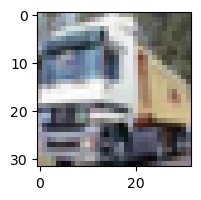

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = imgs_batch[1], labels_batch[1]

print("The label in the picture is {}".format(label))
plt.figure(figsize=(2,2))
plt.imshow(image.transpose(1, 2, 0)) # transpose()函数的作用就是调换数组的行列值的索引值，类似于求矩阵的转置
plt.savefig('cnn-car.pdf')

In [5]:
# 构造一个CIFAR10Dataset类，其将继承自paddle.io.Dataset类，可以逐个数据进行处理
import paddle
import paddle.io as io
from paddle.vision.transforms import Normalize

class CIFAR10Dataset(io.Dataset):
    def __init__(self, folder_path='./aistudio/datasets/cifar-10-batches-py/', mode='train'):
        if mode =='train':
            # 加载batch1-batch4作为训练集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=1, mode='train')
            for i in range(2,5):
                imgs_batch, labels_batch = load_cifar10_batch(folder_path=folder_path, batch_id=i, mode='train')
                self.imgs, self.labels = np.concatenate([self.imgs, imgs_batch]), np.concatenate([self.labels, labels_batch])
        elif mode =='dev':
            # 加载batch5作为验证集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=5, mode='dev')
        elif mode =='test':
            # 加载测试集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, mode='test')
        self.transform = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], data_format='CHW')

    def __getitem__(self, idx):
        img, label = self.imgs[idx], self.labels[idx]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.imgs)
    
paddle.seed(100)
train_dataset = CIFAR10Dataset(folder_path='./aistudio/datasets/cifar-10-batches-py/', mode='train')
dev_dataset = CIFAR10Dataset(folder_path='./aistudio/datasets/cifar-10-batches-py/', mode='dev')
test_dataset = CIFAR10Dataset(folder_path='./aistudio/datasets/cifar-10-batches-py/', mode='test')

In [6]:
# 模型构建
from paddle.vision.models import resnet18

resnet18_model = resnet18()

In [7]:
import paddle.nn.functional as F 
import paddle.optimizer as opt
from nndl_5_2 import RunnerV3, metric

# 指定运行设备
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')

# 学习率大小
lr = 0.001
# 批次大小
batch_size = 64
# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=64)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)

# 定义网络
model = resnet18_model
# 定义优化器，这里使用Adam优化器以及l2正则化策略，相关内容在7.3.3.2和7.6.2中会进行详细介绍
optimizer = opt.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=0.005)
# 定义损失函数
loss_fn = F.cross_entropy
# 定义评价指标
metric = metric.Accuracy(is_logist=True)
# 实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
# 启动训练
log_steps = 3000
eval_steps = 3000
runner.train(train_loader, dev_loader, num_epochs=30, log_steps=log_steps, eval_steps=eval_steps,save_path='best_model_CIFAR10_ResNet18.pdparams')


C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\paddle\nn\layer\norm.py:712: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


[Train] epoch: 0/30, step: 0/18750, loss: 8.13793
[Train] epoch: 4/30, step: 3000/18750, loss: 0.83100


C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\paddle\fluid\dygraph\math_op_patch.py:275: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.int32, the right dtype will convert to paddle.int64
  warnings.warn(


[Evaluate]  dev score: 0.67050, dev loss: 0.96891
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.67050
[Train] epoch: 9/30, step: 6000/18750, loss: 0.69833
[Evaluate]  dev score: 0.71000, dev loss: 0.86276
[Evaluate] best accuracy performence has been updated: 0.67050 --> 0.71000
[Train] epoch: 14/30, step: 9000/18750, loss: 0.72223
[Evaluate]  dev score: 0.71660, dev loss: 0.84651
[Evaluate] best accuracy performence has been updated: 0.71000 --> 0.71660
[Train] epoch: 19/30, step: 12000/18750, loss: 0.57970
[Evaluate]  dev score: 0.73320, dev loss: 0.80187
[Evaluate] best accuracy performence has been updated: 0.71660 --> 0.73320
[Train] epoch: 24/30, step: 15000/18750, loss: 0.53473
[Evaluate]  dev score: 0.71590, dev loss: 0.85712
[Train] epoch: 28/30, step: 18000/18750, loss: 0.64762
[Evaluate]  dev score: 0.72610, dev loss: 0.84625
[Evaluate]  dev score: 0.72990, dev loss: 0.81573
[Train] Training done!


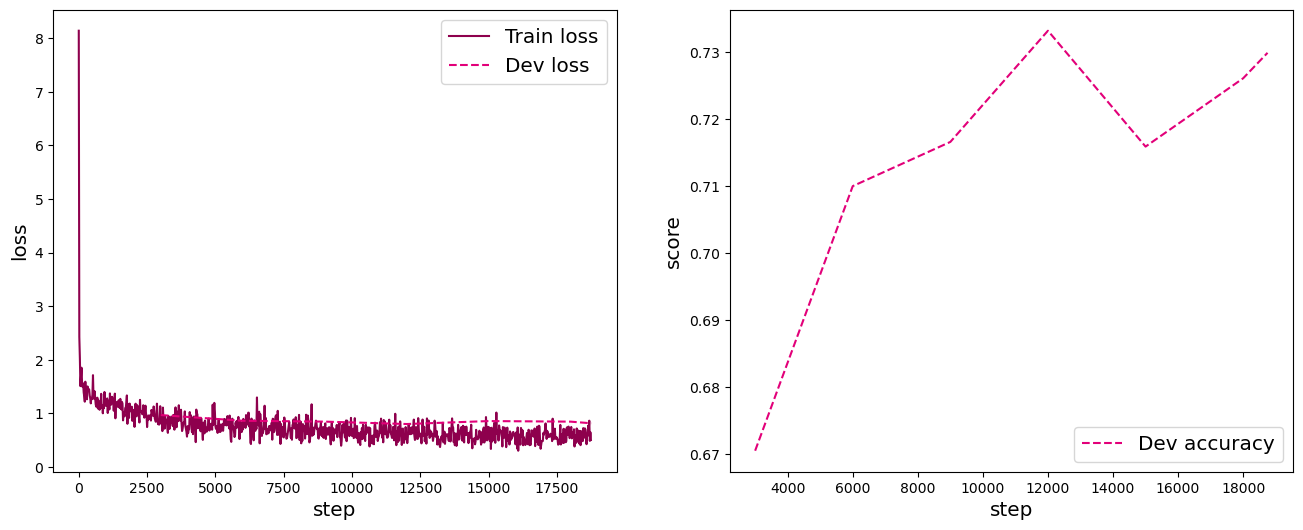

In [8]:
from nndl_5_2 import plot_training_loss_acc

plot_training_loss_acc(runner, fig_name='cnn-loss4.pdf')

In [9]:
# 模型评价
# 加载最佳模型
runner.load_model('best_model_CIFAR10_ResNet18.pdparams')

score, loss = runner.evaluate(test_loader)
print(f'[Test] accuracy/loss: {score:.4f}/{loss:.4f}')


C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\paddle\fluid\dygraph\math_op_patch.py:275: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.int32, the right dtype will convert to paddle.int64
  warnings.warn(


[Test] accuracy/loss: 0.7283/0.8273


The true category is ship and the predicted category is ship


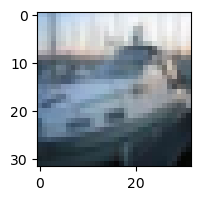

In [10]:
id2label = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
# 获取测试集中的一个batch的数据
X, label_id = next(test_loader())
logits = runner.predict(X)
# 多分类，使用softmax计算预测概率
pred = F.softmax(logits)
# 获取概率最大的类别
pred_class_id = paddle.argmax(pred[2]).numpy()
label_id = label_id[2][0].numpy()
pred_class = id2label[pred_class_id[0]]
label = id2label[label_id[0]]

# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label, pred_class))

# 可视化图片
plt.figure(figsize=(2,2))
imgs, labels = load_cifar10_batch(folder_path='./aistudio/datasets/cifar-10-batches-py/', mode='test')
plt.imshow(imgs[2].transpose(1,2,0))
plt.savefig('cnn-test-vis.pdf')

In [12]:
# 基于自定义的ResNet18网络进行图像分类实验
import paddle.nn.functional as F
import paddle.optimizer as opt
from nndl_5_2 import RunnerV3, metric, op

# 指定运行设备
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')

# 学习率大小
lr = 0.001
# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)

# 定义网络
model = op.Model_ResNet18(in_channels=3, num_classes=10, use_residual=True)

# 定义优化器，这里使用Adam优化器以及l2正则化策略，相关内容在7.3.3.2和7.6.2中会进行详细介绍
optimizer = opt.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=0.005)

# 定义损失函数
loss_fn = F.cross_entropy
# 定义评价指标
metric = metric.Accuracy(is_logist=True)

# 实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)

# 启动训练
log_steps = 3000
eval_steps = 3000
runner.train(train_loader, dev_loader, num_epochs=30, log_steps=log_steps, eval_steps=eval_steps, save_path='best_CIFAR10_Model_ResNet18.pdparams')

C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\paddle\nn\layer\norm.py:712: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


[Train] epoch: 0/30, step: 0/18750, loss: 3.56465
[Train] epoch: 4/30, step: 3000/18750, loss: 1.07047


C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\paddle\fluid\dygraph\math_op_patch.py:275: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.int32, the right dtype will convert to paddle.int64
  warnings.warn(


[Evaluate]  dev score: 0.65850, dev loss: 0.99117
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.65850
[Train] epoch: 9/30, step: 6000/18750, loss: 0.94927
[Evaluate]  dev score: 0.70510, dev loss: 0.86345
[Evaluate] best accuracy performence has been updated: 0.65850 --> 0.70510
[Train] epoch: 14/30, step: 9000/18750, loss: 0.72176
[Evaluate]  dev score: 0.72440, dev loss: 0.80785
[Evaluate] best accuracy performence has been updated: 0.70510 --> 0.72440
[Train] epoch: 19/30, step: 12000/18750, loss: 0.67393
[Evaluate]  dev score: 0.71080, dev loss: 0.88956
[Train] epoch: 24/30, step: 15000/18750, loss: 0.76530
[Evaluate]  dev score: 0.73240, dev loss: 0.79012
[Evaluate] best accuracy performence has been updated: 0.72440 --> 0.73240
[Train] epoch: 28/30, step: 18000/18750, loss: 0.51304
[Evaluate]  dev score: 0.70860, dev loss: 0.89178
[Evaluate]  dev score: 0.73640, dev loss: 0.79299
[Evaluate] best accuracy performence has been updated: 0.73240 --> 0.73640
[Tr

In [13]:
# 加载最优模型
runner.load_model('best_CIFAR10_Model_ResNet18.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print(f"[Test] accuracy/loss: {score:.4f}/{loss:.4f}")

[Test] accuracy/loss: 0.7286/0.8208
